In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from common.data_loader import load_images
from utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from config.common_path import get_encoded_csv_file
from generative_models.vae import VAE
from config import ExperimentConfig
from experiments.experiment import Experiment
from analysis.encode_decode import decode
from analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from analysis.cluster_utils import get_cluster_groups,assign_manual_label_and_confidence, get_samples_for_cluster
from analysis import ManualAnnotation, Cluster, ClusterGroup
from PIL import Image


%matplotlib inline


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Set experiment parameters

In [2]:
# N_3 = 32
# N_2 = 128
# N_1 = 64
# Z_DIM = 10
# run_id = 2

# ROOT_PATH = "/Users/sunilkumar/concept_learning_old/image_classification_supervised/"
# exp_config = ExperimentConfig(ROOT_PATH,
#                               4,
#                               Z_DIM,
#                               [N_1, N_2, N_3],
#                               num_val_samples=128,
#                               confidence_decay_factor=5,
#                               num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_TWO_TIMES_ELBOW)

N_3 = 64
N_2 = 128
N_1 = 64
Z_DIM = 20
run_id = 1

ROOT_PATH = "/Users/sunilkumar/concept_learning_old/image_classification_supervised/"
exp_config = ExperimentConfig(ROOT_PATH,
                              4,
                              Z_DIM,
                              [N_1, N_2, N_3],
                              num_val_samples=128,
                              confidence_decay_factor=5,
                              num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_TWO_TIMES_ELBOW)

exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name

cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"


# Load the trained model

In [3]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=Z_DIM,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

W0709 17:11:37.360512 140735495193472 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:65: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 17:11:37.371012 140735495193472 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:84: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0709 17:11:37.372101 140735495193472 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/tensorflow_wrappers/layers.py:36: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0709 17:11:37.499169 140735495193472 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:143: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0709 17:11:37.529242 140735495193472 deprecation_wrapper.py:119

 [*] Reading checkpoints...
ckpt_name VAE.model-3740
 [*] Success to read VAE.model-3740
 [*] Load SUCCESS
Number of steps completed=3740
Number of epochs completed 4.0


# Read the latent vectors for train data

In [4]:
filename  = get_encoded_csv_file(N_2, N_3, Z_DIM, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names = get_latent_vector_column(Z_DIM)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=1 z_min=-4.809633 z_max=4.6380014
Latent vectors shape (59840, 20)


# Load training images,  labels and manual annotations

In [5]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
train_val_iterator, images, labels, manual_annotation_np = load_images(exp_config,
                                                                    "train",
                                                                    manual_annotation_file)
unique_labels = train_val_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Loaded manual annotation
Number of samples with manual confidence 49697
Number of epochs completed 4.0


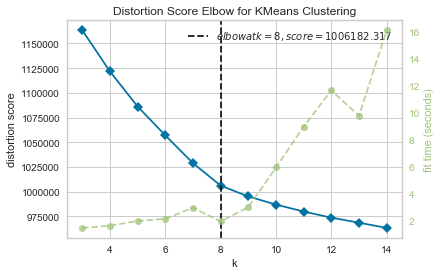

In [6]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [7]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_

 [*] Reading checkpoints...
ckpt_name VAE.model-3740
 [*] Success to read VAE.model-3740
 [*] Load SUCCESS


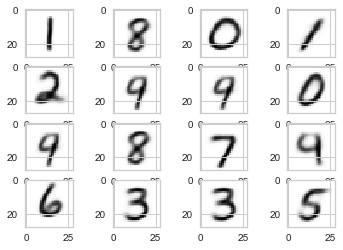

In [8]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config)
    display_cluster_center_images(decoded_images, image_filename, cluster_centers, exp_config, run_id)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [9]:
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [1,8,0,1,
                                               2,9,9,0,
                                               9,8,7,9,
                                               6,3,3,5]
    manual_annotation_json["manual_confidence"] = [1,0.85,1,1,
                                                   0.85,0.7,0.7,0.9,
                                                   0.6,0.85,0.9,0.6,
                                                   0.8,0.85,0.85,0.75
                                                  ]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [10]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [11]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [12]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


In [13]:
def plot_number_of_samples_vs_label(cluster_group, title_string):
    for cluster in cluster_group:
        cluster_num = cluster.id
        cluster_details = cluster.details
        _df = cluster_details["cluster_data_frame"]
        fig = plt.figure(figsize=(20, 8))
        #fig.tight_layout()
        plt.title(title_string.format(cluster_group_name, cluster_num),fontsize=22)
        plt.xlabel("Label")
        plt.ylabel("Number of samples")
        number_of_samples_for_label = get_pmf_y_given_z(_df, "label", exp_config.Z_DIM, normalized=False)
        plt.bar(x=number_of_samples_for_label.index.values + 0.5,
                height=number_of_samples_for_label,
                width=0.8, align="center")
        plt.text(0.22, 0.84, "Manual Label : {},{}".format(manual_labels[cluster_num], manual_confidence[cluster_num]),
                bbox=dict(facecolor='red', alpha=0.5),
                transform=fig.transFigure)
        plt.xticks(number_of_samples_for_label.index.values + 0.5, number_of_samples_for_label.index.values)
        plt.ylim(0, max(number_of_samples_for_label) * 1.1) 
        plt.grid(which="major", axis="x")

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


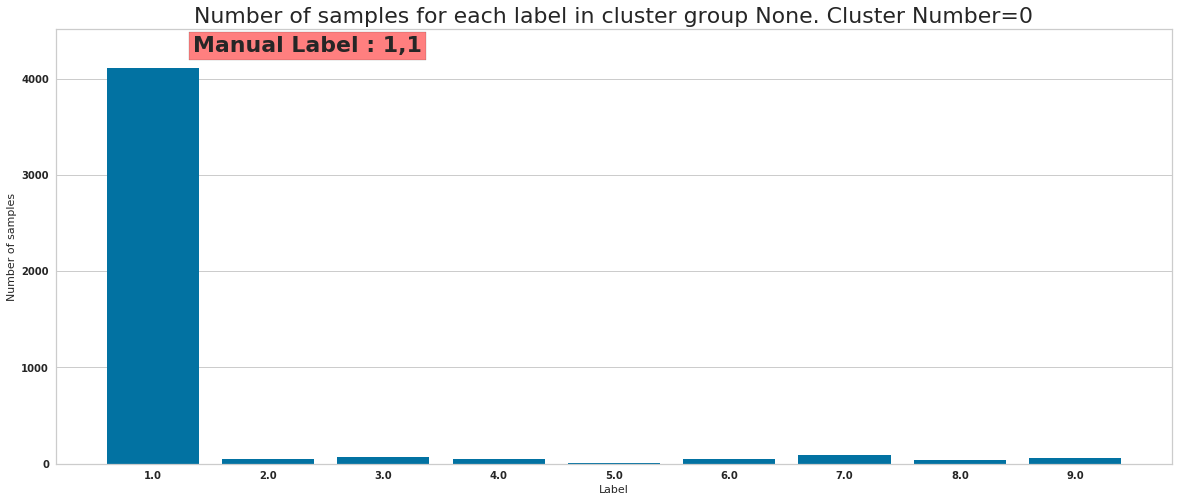

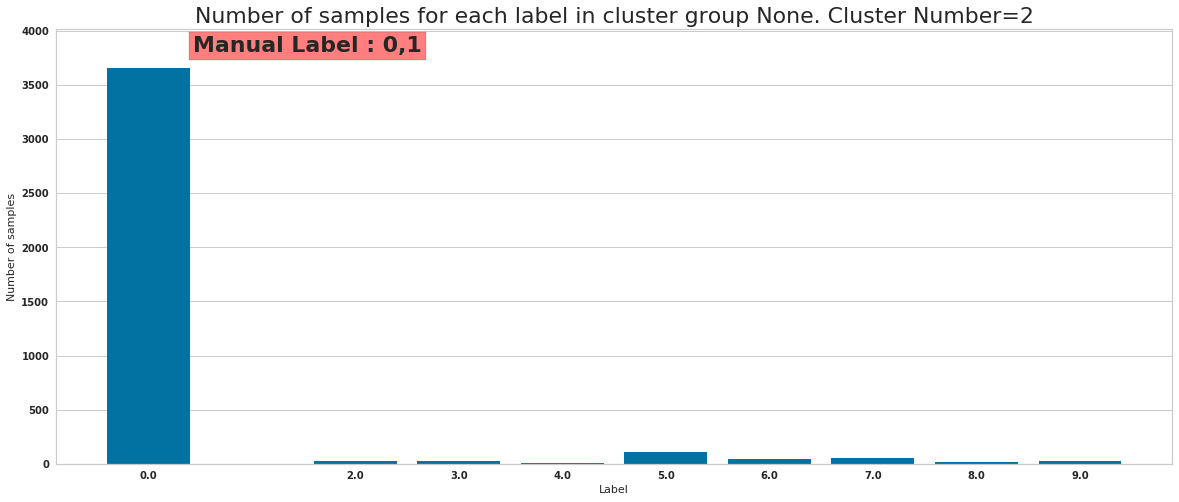

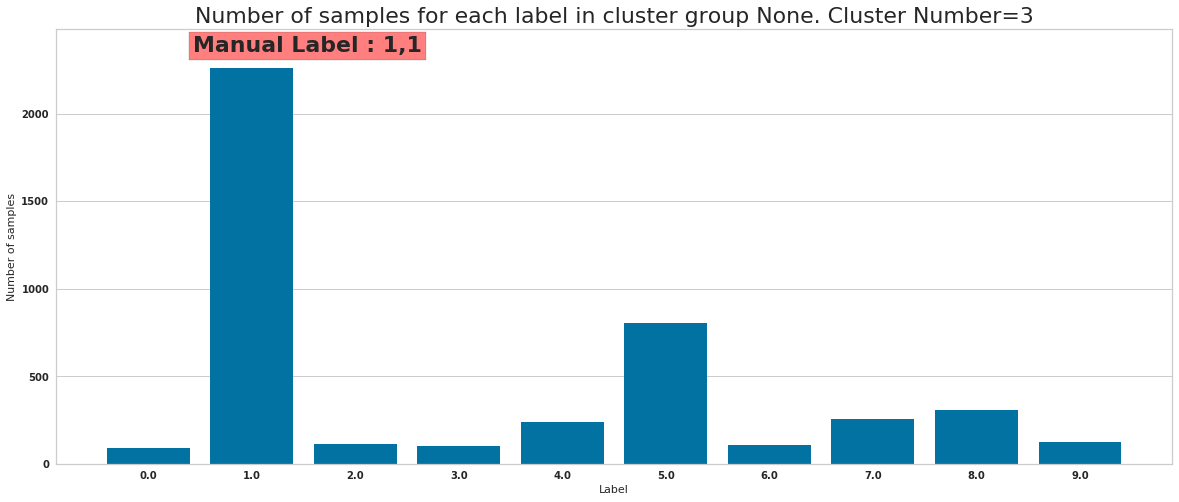

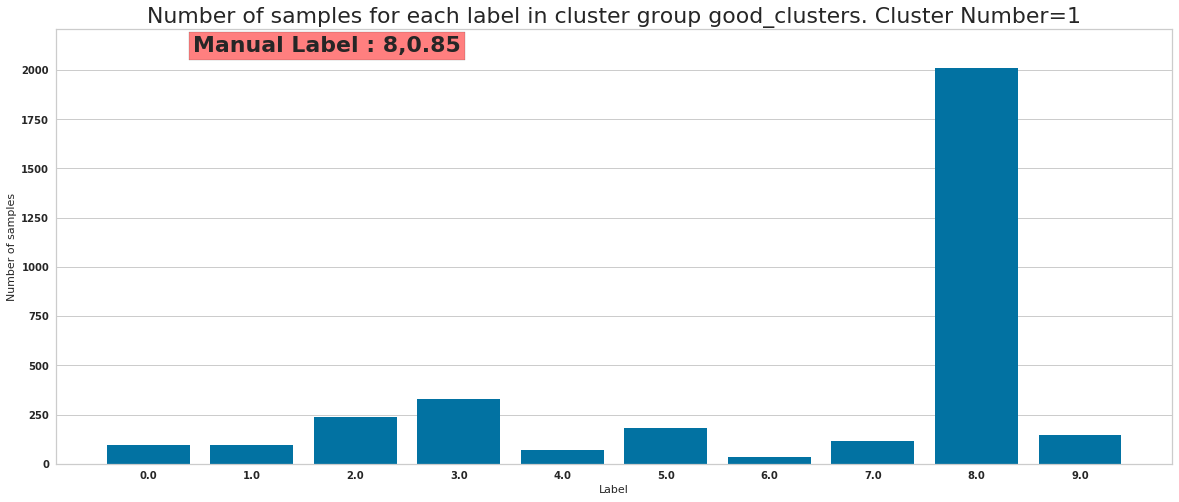

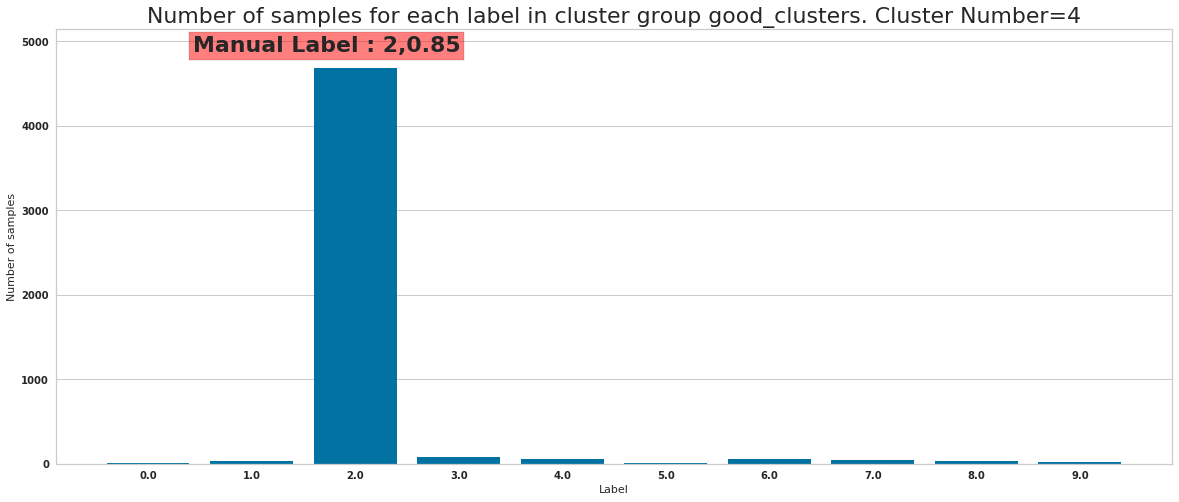

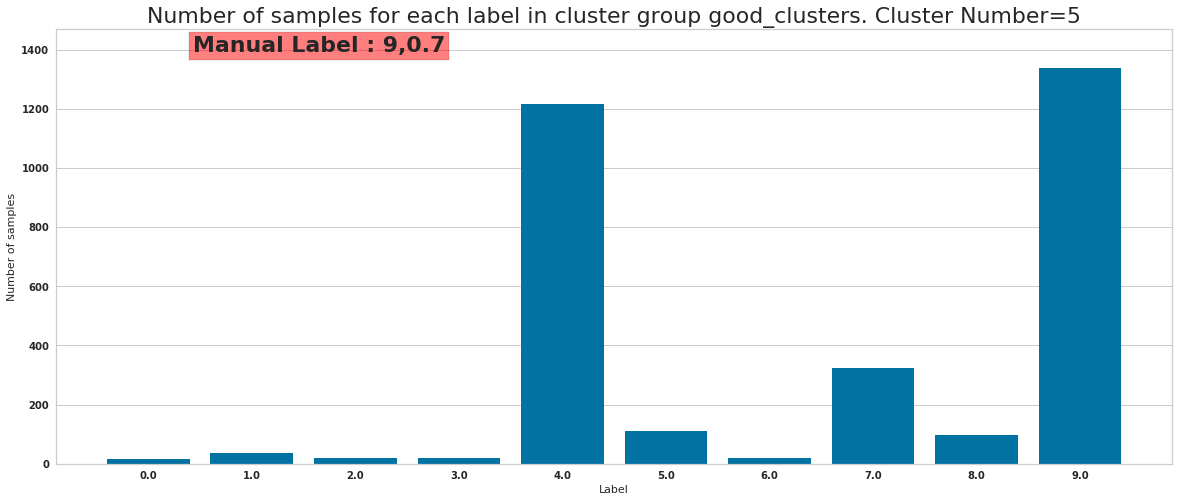

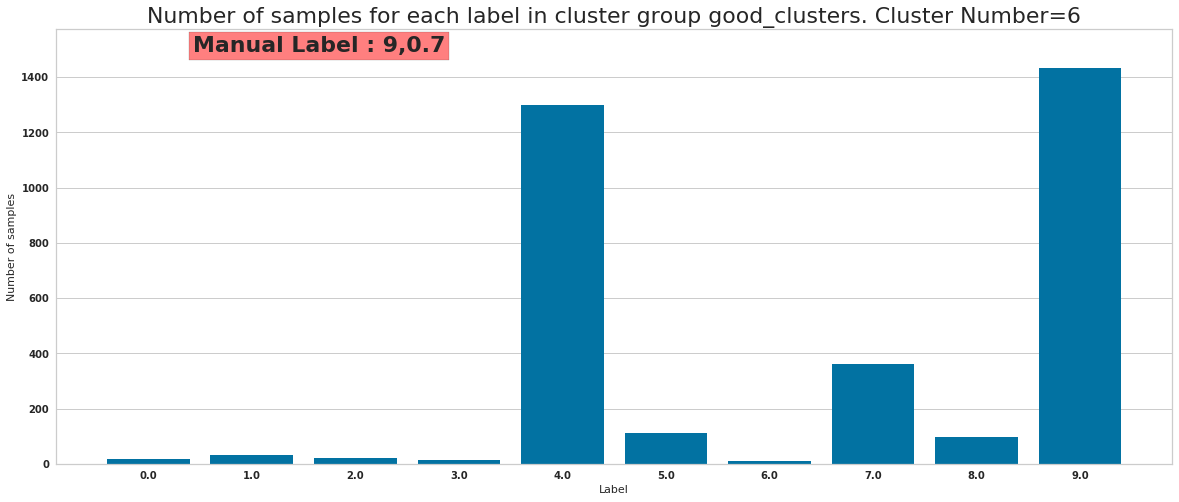

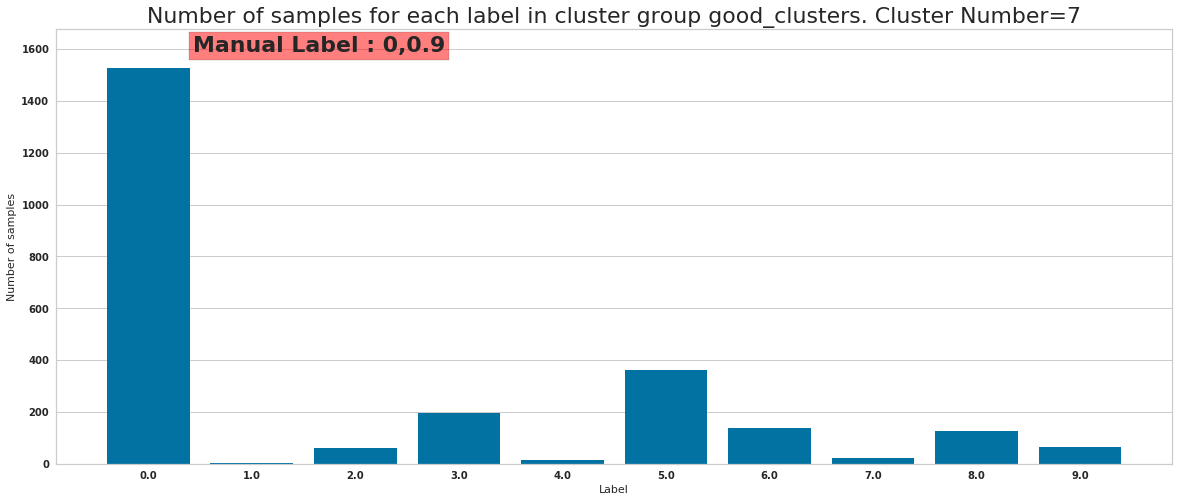

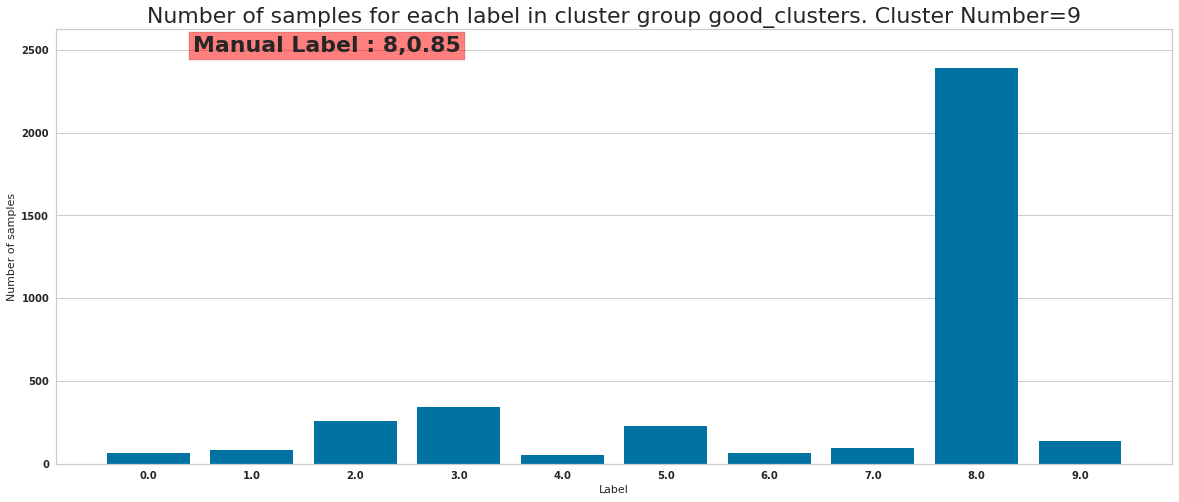

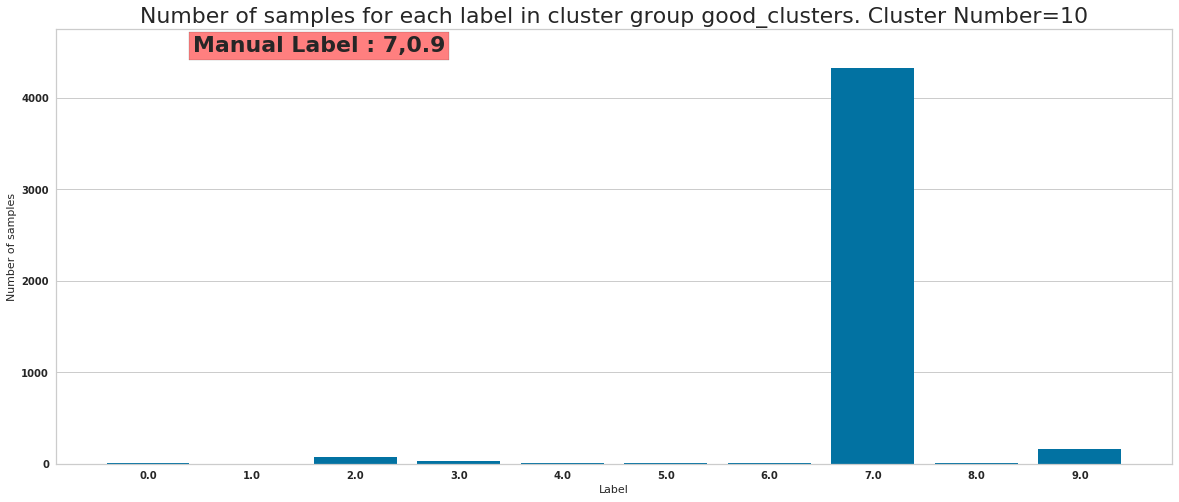

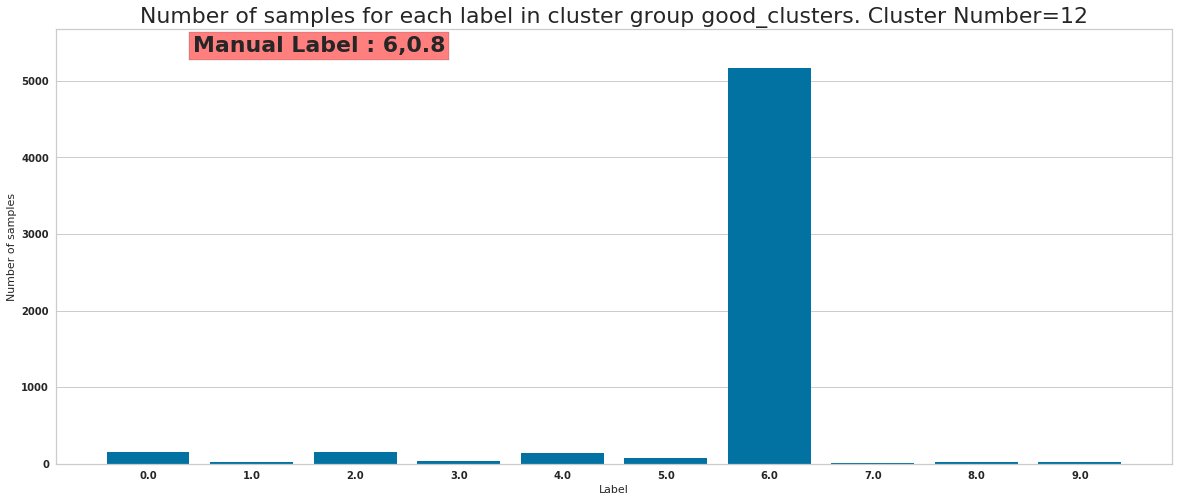

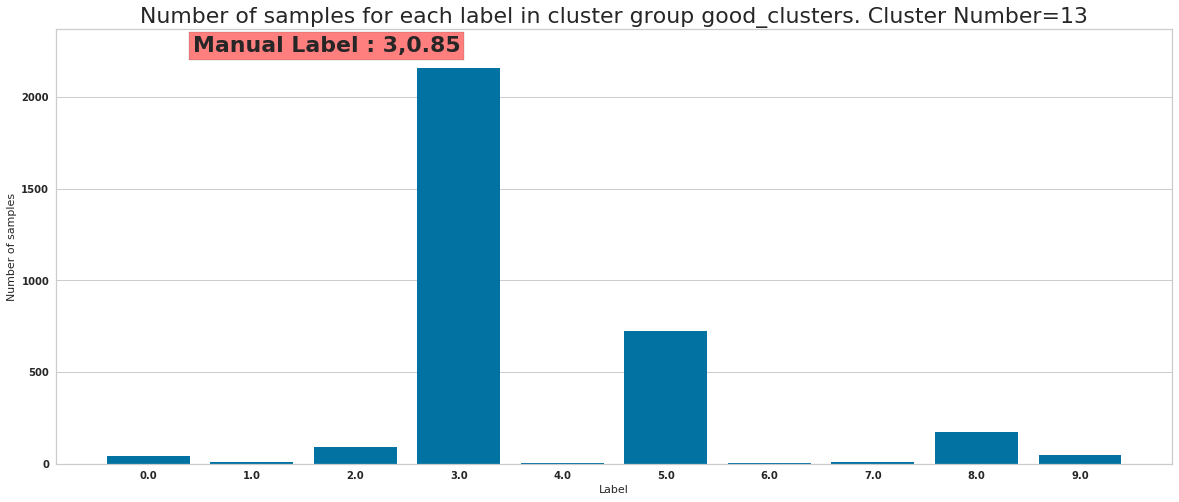

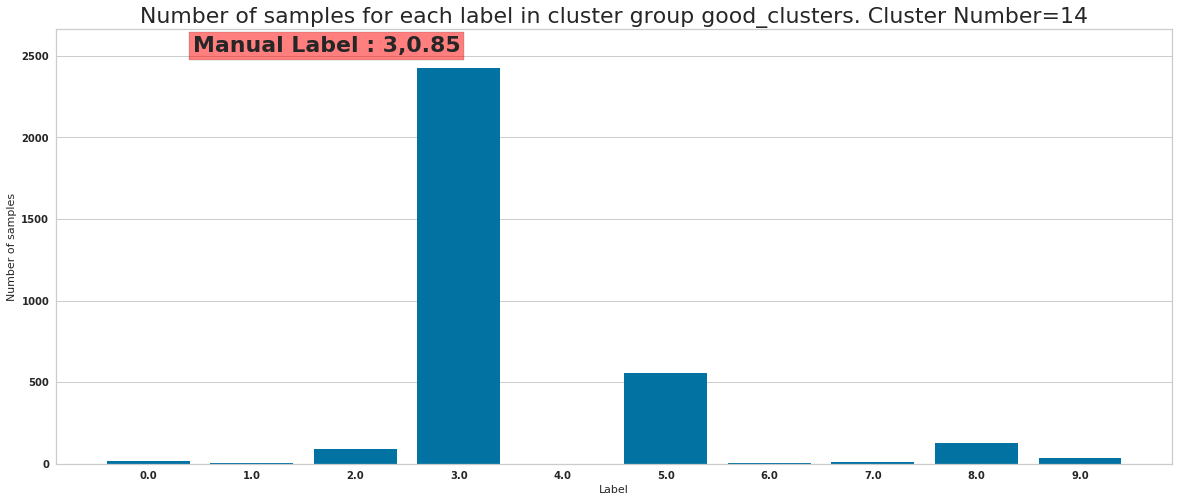

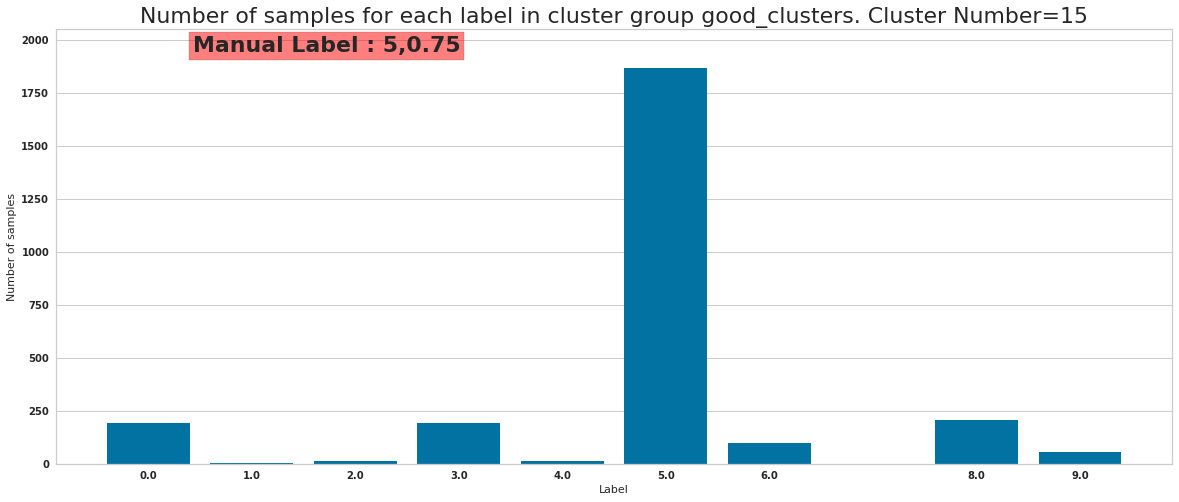

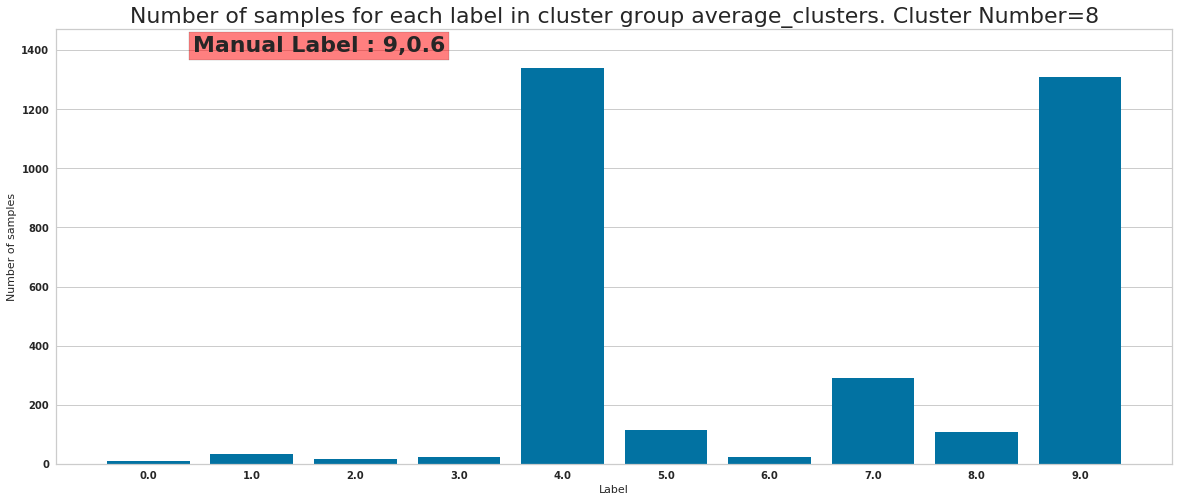

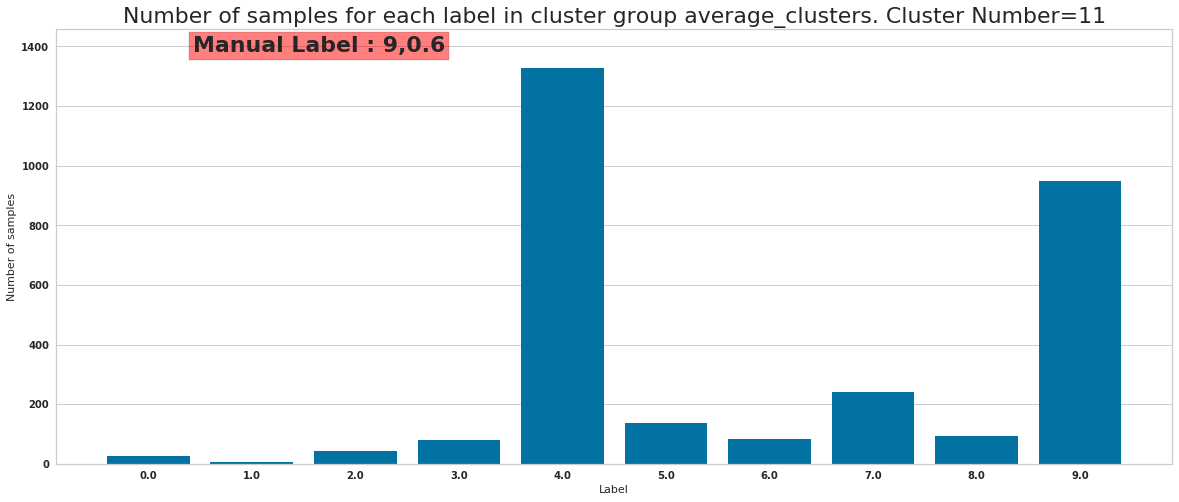

In [14]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )

# For each sample, compute distance from respective cluster center

In [15]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)

In [16]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
def cluster_next_level(df, processed_clusters = [],
                       cluster_column_name_2 = cluster_column_name_2,
                       cluster_type = "unknown_cluster"):
    if cluster_type in cluster_group_dict.keys():
        for cluster in cluster_group_dict[cluster_type]:
            print(cluster.id)
            if cluster.id in processed_clusters:
                continue
            _indices =np.where( cluster_labels == cluster.id)
            _df = df.iloc[_indices]

            _latent_vectors = _df[z_col_names].values
            _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(2,
                                                                                                _latent_vectors,
                                                                                                exp_config)
            df[cluster_column_name_2].iloc[_indices] = _cluster_labels
            image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

            display_cluster_center_images(_decoded_images, image_filename, _cluster_centers, exp_config, run_id)

            return cluster, _cluster_centers, _cluster_labels
    return None, None, None
    

In [18]:
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [19]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [(4,9),(4,9)]
level_2_cluster_dict["manual_confidences"] = [0.5,0.5]
level2_manual_annotations[2] = level_2_cluster_dict

level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [(4,9),(4,9)]
level_2_cluster_dict["manual_confidences"] = [0.5,0.5]
level2_manual_annotations[9] = level_2_cluster_dict

level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0, 0]
level2_manual_annotations[11] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[11] = level_2_cluster_dict



In [20]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [21]:
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [22]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers, exp_config, run_id)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [23]:
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [7,7,9,9]
# level_2_cluster_dict["manual_confidences"] = [0.6,0.6,0.8,0.85]


In [24]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [25]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [26]:
K = exp_config.confidence_decay_factor
def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return -K * log(confidence)
def get_confidence(distance):
    return np.exp(-distance/K)

In [27]:
assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 1
(4518, 82) (4518, 62)
Num correct=4105
Cluster 0 Manual Label 1 Percentage correct 90.85878707392652
********************************
Manual Label 8
(3309, 82) (3309, 62)
Num correct=2008
Cluster 1 Manual Label 8 Percentage correct 60.68298579631308
********************************
Manual Label 0
(3960, 82) (3960, 62)
Num correct=3651
Cluster 2 Manual Label 0 Percentage correct 92.1969696969697
********************************
Manual Label 1
(8924, 82) (4406, 62)
Num correct=6363
Cluster 3 Manual Label 1 Percentage correct 71.30210667861945
********************************
Manual Label 2
(5022, 82) (5022, 62)
Num correct=4680
Cluster 4 Manual Label 2 Percentage correct 93.18996415770609
********************************
Manual Label 9
(3196, 82) (3196, 62)
Num correct=1336
Cluster 5 Manual Label 9 Percentage correct 41.80225281602002
********************************
Manual Label 9
(6589, 82) (3393, 62)
Num correct=2767
Cluster 6 Manual Label 9 Percentage correct 41.994232

# Save the dataframe with manual annotations

In [28]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(N_2, N_3, Z_DIM, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(N_2, N_3, Z_DIM, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([7827., 3960., 9428., 3196., 5910., 3264., 8325., 2981., 9031.,
        5918.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

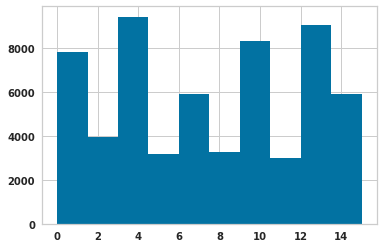

In [29]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [30]:
def plot_distance_distribution(clusters):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 22}
    legend_string = "Cluster Number={} Label={}"
    matplotlib.rc('font', **font)
    plt.figure(figsize=(20, 8))
    for cluster_num in clusters:
        _df = get_samples_for_cluster(df, cluster_num, cluster_column_name)
        col_name = "distance_{}".format(cluster_num)
        v, b = np.histogram(_df[col_name].values, bins=20, normed=False)
        v = v/np.sum(v)
        plt.plot(b[:-1], v, label = legend_string.format(cluster_num, manual_labels[cluster_num]))
        plt.xlabel("Distance from cluster center")
        plt.ylabel("Number of samples")
        plt.title("Distribution of distance from cluster center")
    plt.legend()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()


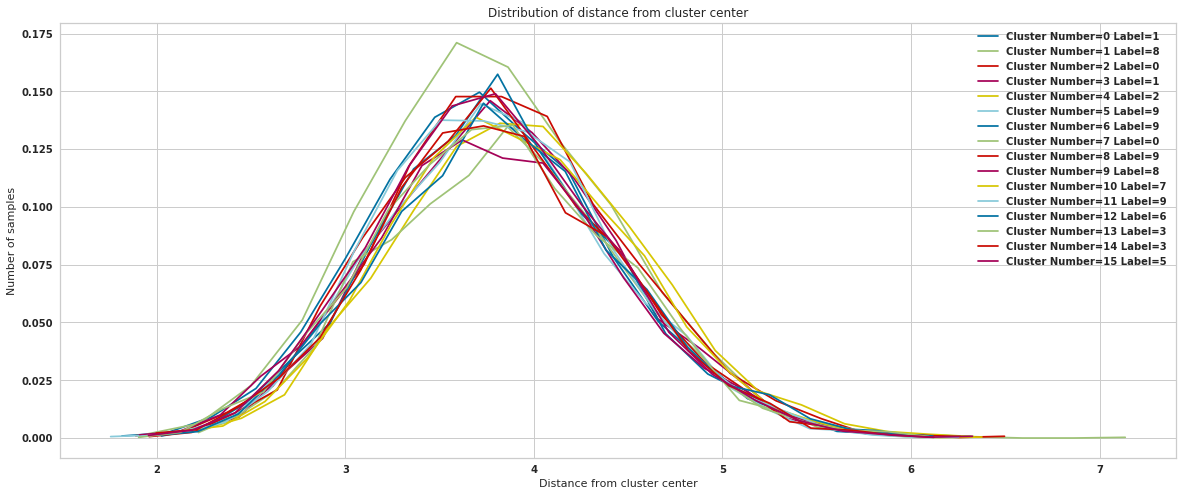

In [31]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

Text(0,0.5,'Percentage Correct')

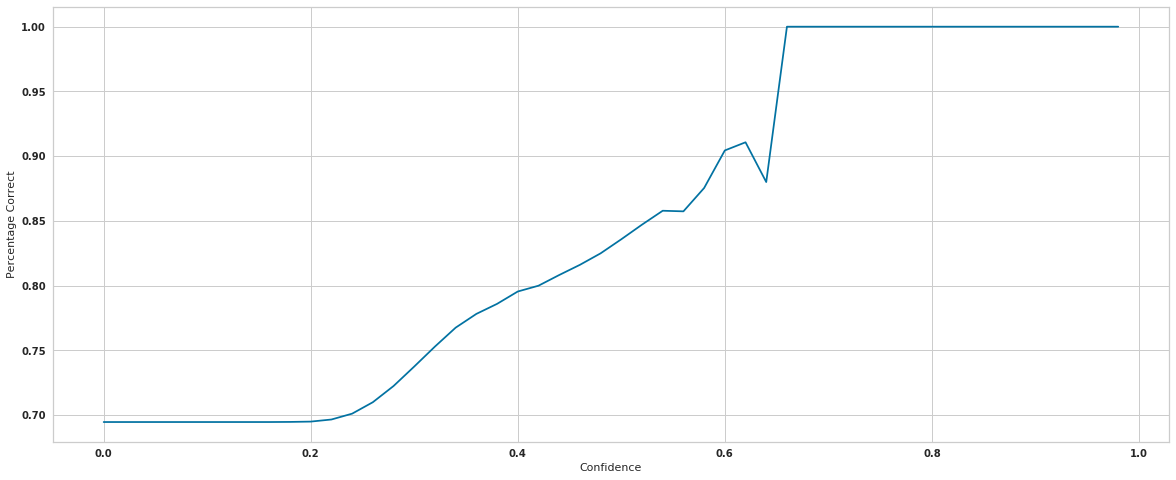

In [32]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

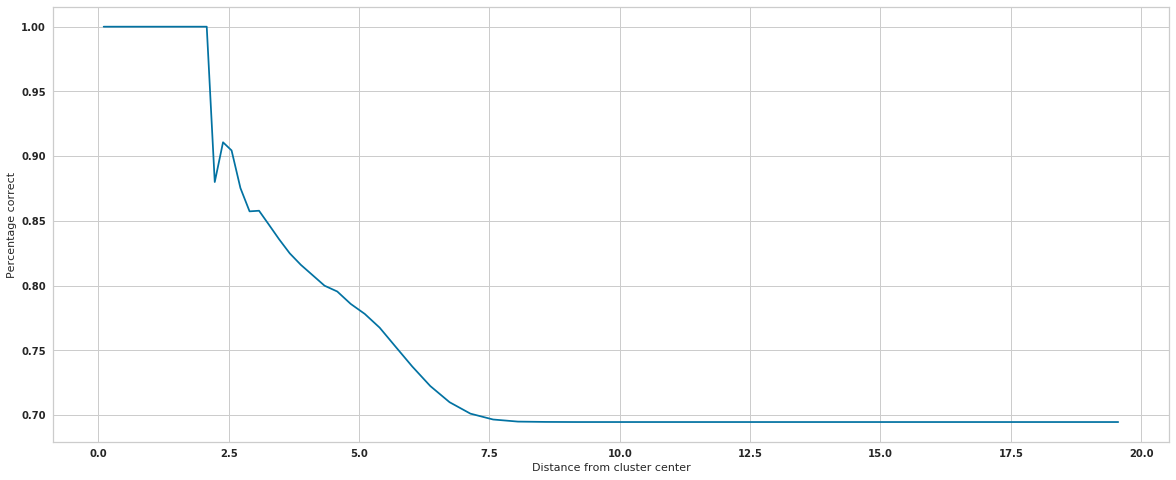

In [33]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [34]:
from shutil import copy2

In [35]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging 
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

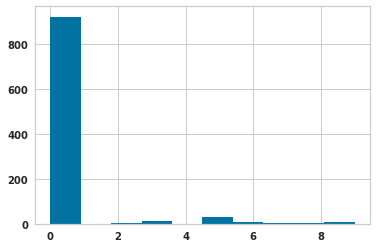

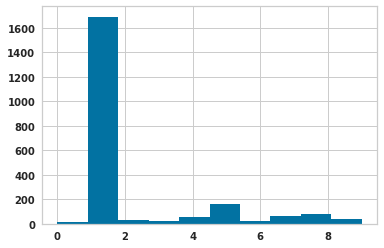

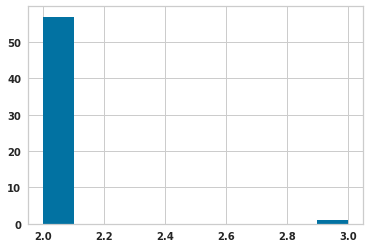

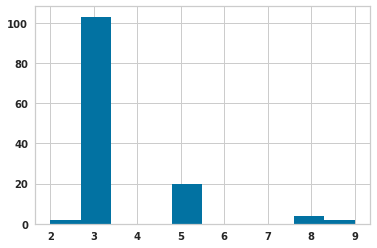

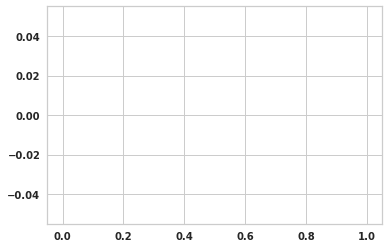

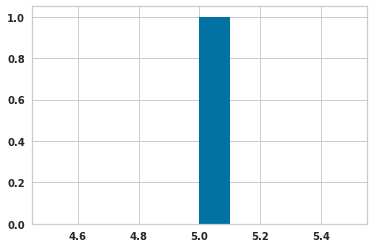

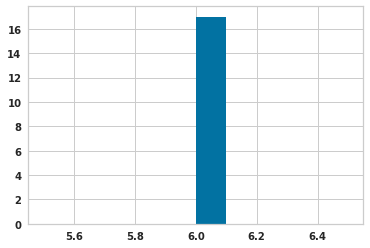

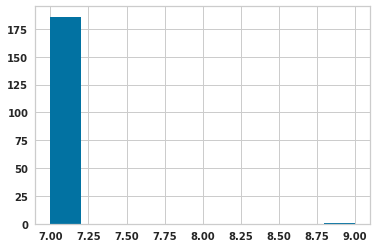

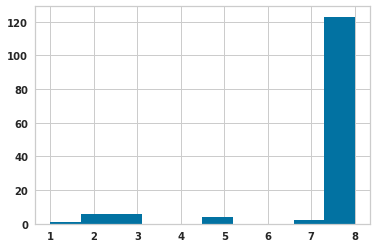

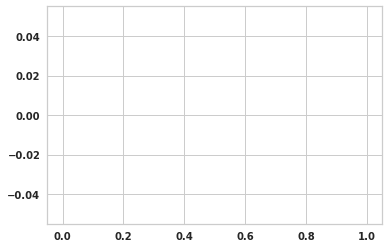

In [36]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [37]:
df.columns

Index(['mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4', 'mu_5', 'mu_6', 'mu_7', 'mu_8',
       'mu_9', 'mu_10', 'mu_11', 'mu_12', 'mu_13', 'mu_14', 'mu_15', 'mu_16',
       'mu_17', 'mu_18', 'mu_19', 'sigma_0', 'sigma_1', 'sigma_2', 'sigma_3',
       'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8', 'sigma_9',
       'sigma_10', 'sigma_11', 'sigma_12', 'sigma_13', 'sigma_14', 'sigma_15',
       'sigma_16', 'sigma_17', 'sigma_18', 'sigma_19', 'z_0', 'z_1', 'z_2',
       'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'z_10', 'z_11', 'z_12',
       'z_13', 'z_14', 'z_15', 'z_16', 'z_17', 'z_18', 'z_19', 'label',
       'cluster_level_1', 'distance_0', 'distance_1', 'distance_2',
       'distance_3', 'distance_4', 'distance_5', 'distance_6', 'distance_7',
       'distance_8', 'distance_9', 'distance_10', 'distance_11', 'distance_12',
       'distance_13', 'distance_14', 'distance_15', 'cluster_level_2',
       'manual_annotation', 'manual_annotation_confidence',
       'distance_to_confidenc

In [38]:
df[(df["cluster_level_1"] == 8) & (df["cluster_level_2"] == 0)]

,mu_0,mu_1,mu_2,mu_3,mu_4,mu_5,mu_6,mu_7,mu_8,mu_9,...,distance_10,distance_11,distance_12,distance_13,distance_14,distance_15,cluster_level_2,manual_annotation,manual_annotation_confidence,distance_to_confidence


In [39]:
x = np.linspace(0, 5, 20)


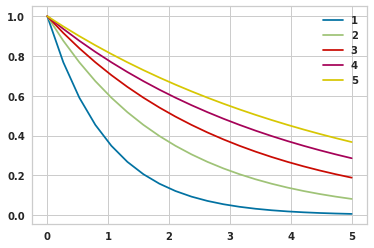

In [40]:
for K in [1,2,3,4,5]:
    y = np.exp(-1*x/K)
    plt.plot(x,y, label=str(K))

plt.legend()